In [1]:
from collections import OrderedDict
import re
import os

print(os.getcwd()) 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot_a_task, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')
device="cuda:1"
run_dir = "../results/trained_ckpt_and_eval_results"

d:\Documemts\submissions\ICLR 2025\code\in-context-learning2025.3.11\ICL-OOD\src


d:\Software\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = read_run_dir(run_dir, device=device)
#df  # list all the runs in our run_dir

FileNotFoundError: [Errno 2] No such file or directory: '../results/trained_ckpt_and_eval_results\\linear_regression+quadratic_regression+relu_2nn_regression+cubic_regression+sigmoid_2nn_regression\\7ce6834a-eae5-46d8-a0b9-4be3e22463ee\\config.yaml'

In [ ]:
fig_title_mapping = {
    'linear_regression': 'linear regression',
    'quadratic_regression': 'quadratic regression',
    'relu_2nn_regression': 'relu NN regression',
    'random_int_mapping-num_classes-10000-shift_low-100-shift_high-150': 'retrieval',
    'random_int_mapping-num_classes-10000-shift_low-10-shift_high-20': 'retrieval',
    'random_int_mapping-num_classes-10000-shift_low-500-shift_high-600': 'retrieval',
    'linear_regression_random_mapping-shift_low-100-shift_high-200': 'linear regression + retrieval', 
    'linear_regression_random_mapping-shift_low-500-shift_high-600': 'linear regression + retrieval', 
    'linear_regression_random_mapping-shift_low-3000-shift_high-3100': 'linear regression + retrieval',
    'quadratic_regression_random_mapping': 'quadratic regression + retrieval',
    "sqrt_regression": 'sqrt regression',
    "linear_quadratic_regression": 'linear quadratic regression',
    "cubic_regression": 'cubic regression',
    "sigmoid_2nn_regression": 'sigmoid NN regression',
    
}

## Reproduce Figure 1

eval task:  linear_regression
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 105738.76it/s]


pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]


pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 46345.90it/s]


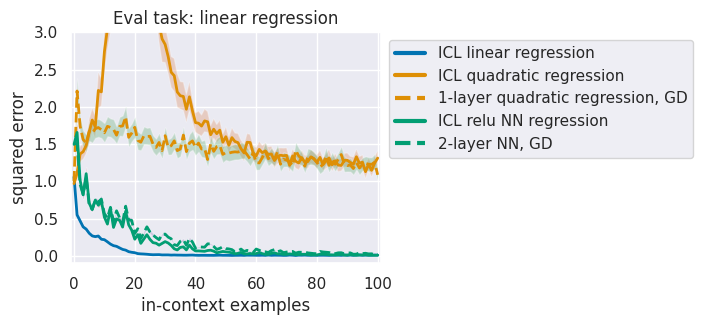

eval task:  quadratic_regression
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 109416.63it/s]


pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]


pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 46863.73it/s]


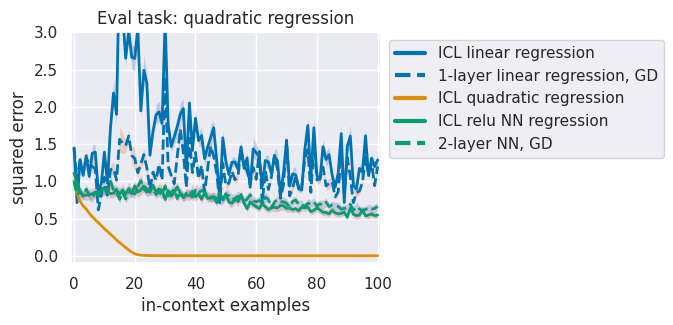

eval task:  relu_2nn_regression
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 130257.89it/s]


pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]


pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 51150.05it/s]


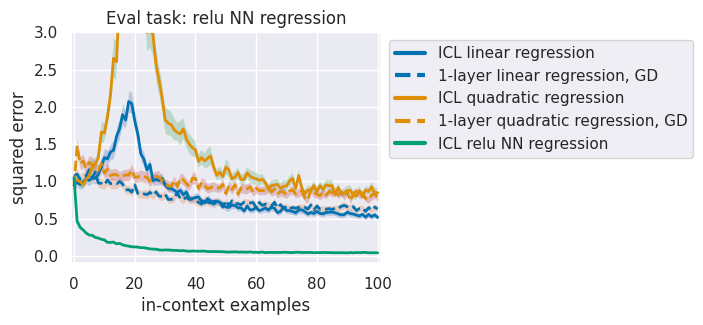

In [ ]:
pretrain_tasks = [
    {
        "task_name":"linear_regression",
        "step":-1,
        "run_id":"436c5fab-f524-4663-b7eb-155144477e05",
        'curve_name': "ICL linear regression"
    },
    {
        "task_name":"quadratic_regression",
        "step":-1,
        "run_id":"9f9b08e3-17f0-4310-af4d-437bd6ffaadb",
        'curve_name': "ICL quadratic regression"
    },
    {
        "task_name":"relu_2nn_regression",
        "step":-1,
        "run_id":"c9d388fe-0966-4b2b-9e0b-eb0fc9c9ad90",
        'curve_name': "ICL relu NN regression"
    },
    
]


eval_tasks = []
eval_tasks = ['linear_regression', 'quadratic_regression', 'relu_2nn_regression']
for eval_task_name in eval_tasks:
    fig, ax = plt.subplots(1, 1)
    color=0
    print("eval task: ", eval_task_name)
    for pretrain_task in pretrain_tasks:
        task_name = pretrain_task["task_name"]
        run_id = pretrain_task["run_id"]
        step = pretrain_task["step"]
        curve_name = pretrain_task['curve_name'] 
        print("pt task: ",task_name)
        ckpt_save_path = task_name if "task_para" not in pretrain_task else pretrain_task["task_para"]

        run_path = os.path.join(run_dir, ckpt_save_path, run_id)

        
        def valid_row(r):
            if 'AR' in r.task or 'linear_quadratic' in r.task or '+' in r.task or \
                'rank' in r.task or "random_int_mapping" in r.task or \
                "linear_regression_random_mapping" in r.task or "linear_regression_diversity" in r.task or "power_regression" in r.task:
                #print(r.run_id , run_id)
                return r.run_id == run_id
            return r.task == task_name and r.run_id == run_id
        
        metrics = collect_results(run_dir, df, valid_row=valid_row, task_para=ckpt_save_path, step=step)
        #print(metrics)
        _, conf = get_model_from_run(run_path, only_conf=True)
        n_dims = conf.model.n_dims
        models_ = relevant_model_names[task_name]
        models = [b for b in models_ if "GD" not in b or eval_task_name != task_name]
        
        metric = metrics[eval_task_name]
        if "scale" in eval_task_name:
            scale = float(eval_task_name.split("=")[-1])**2
        else:
            scale = 1.0

        fig, ax = basic_plot_a_task(eval_task_name, metric, models=models, max_y=3.0, fig=fig, ax=ax, pretrain_task_name=curve_name, color=color, keep_legend=True)

        color+=1
        

        spec_str=''
        ax.set_title("Eval task: " + fig_title_mapping[ eval_task_name])

        
    
    plt.savefig('/data1/qxwang/codes/in-context-learning/results/figs_for_ICLR25/retrieval/'+eval_task_name+spec_str+'.pdf', bbox_inches='tight')
    plt.show()
    

## Reproduce Figure 3

eval_task:  random_int_mapping-num_classes-10000-shift_low-100-shift_high-150
pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]


pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 26546.23it/s]


pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 26886.56it/s]


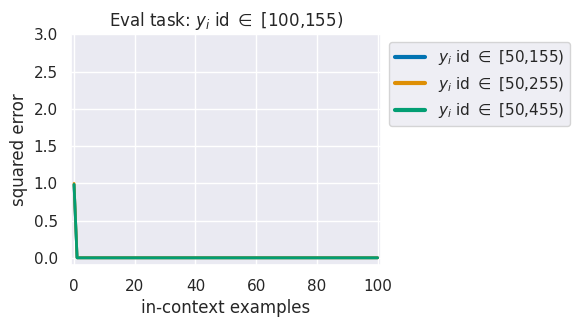

eval_task:  random_int_mapping-num_classes-10000-shift_low-10-shift_high-20
pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]


pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 26379.27it/s]


pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 8097.11it/s]


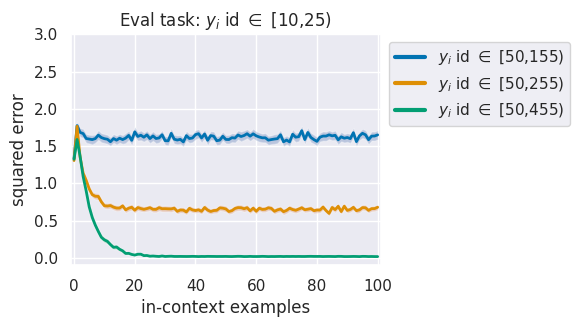

eval_task:  random_int_mapping-num_classes-10000-shift_low-500-shift_high-600
pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]


pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]


pt task:  random_int_mapping


100%|██████████| 1/1 [00:00<00:00, 23431.87it/s]


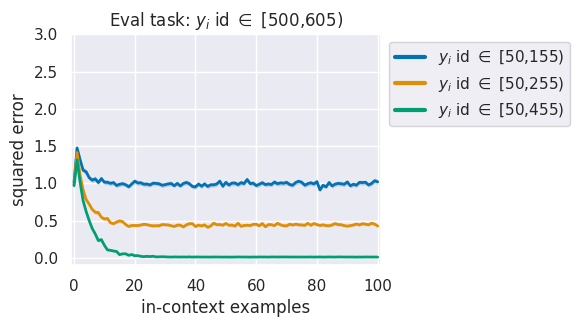

In [ ]:
task_para=None
step=-1

pretrain_tasks = [
    {
        "task_name":"random_int_mapping",
        "step":-1,
        "run_id":"d5382e47-0e98-4701-be93-d0865c8e37c8",
        "task_para": "random_int_mapping_dim7_embedded_10000classes_shift50-150",
        'curve_name': '$y_i$ id $\in$ [50,155)'
    },
    {
        "task_name":"random_int_mapping",
        "step":-1,
        "run_id":"a26658ed-f4be-4bcd-ac02-16a807dc7dd6",
        "task_para": "random_int_mapping_dim7_embedded_10000classes_shift50-250",
        'curve_name': '$y_i$ id $\in$ [50,255)'
    },
    {
        "task_name":"random_int_mapping",
        "step":-1,
        "run_id":"523d5877-9099-461a-9293-f9793b9ccc22",
        "task_para": "random_int_mapping_dim7_embedded_10000classes_shift50-450",
        'curve_name': '$y_i$ id $\in$ [50,455)'
    },
    
]



eval_tasks = ['random_int_mapping-num_classes-10000-shift_low-100-shift_high-150', 'random_int_mapping-num_classes-10000-shift_low-10-shift_high-20', 'random_int_mapping-num_classes-10000-shift_low-500-shift_high-600']
# num_class is the size of the vocabular
for eval_task_name in eval_tasks:
    fig, ax = plt.subplots(1, 1)
    color=0
    print("eval_task: ", eval_task_name)
    for task in pretrain_tasks:
        task_name = task["task_name"]
        run_id = task["run_id"]
        step = task["step"]
        curve_name = task['curve_name'] 
        print("pt task: ",task_name)

        task_para = task["task_para"]
            #curve_name = task_para
            #curve_name = '5classes_'+ task_para[-11:]
            
        run_path = os.path.join(run_dir, task_para, run_id)

        
        def valid_row(r):
            #print('555')

            if 'AR' in r.task or 'linear_quadratic' in r.task or '+' in r.task or \
                'rank' in r.task or "random_int_mapping" in r.task or \
                "linear_regression_random_mapping" in r.task or "linear_regression_diversity" in r.task or "power_regression" in r.task:
                #print(r.run_id , run_id)
                return r.run_id == run_id
            return r.task == task_name and r.run_id == run_id
        
        metrics = collect_results(run_dir, df, valid_row=valid_row, task_para=task_para, step=step)
        #print(metrics)
        _, conf = get_model_from_run(run_path, only_conf=True)
        n_dims = conf.model.n_dims

        models = relevant_model_names[task_name]

        metric = metrics[eval_task_name]

        fig, ax = basic_plot_a_task(eval_task_name, metric, models=models, max_y=3.0, fig=fig, ax=ax, pretrain_task_name=curve_name, color=color, keep_legend=True)

        color+=1
        
        if "shift_low-100-shift_high-150" in eval_task_name:
            spec_str = '_100-150'
            ax.set_title("Eval task: " + '$y_i$ id $\in$ [100,155)')
        elif "shift_low-10-shift_high-20" in eval_task_name:
            spec_str = '_10-20'
            ax.set_title("Eval task: " + '$y_i$ id $\in$ [10,25)')
        elif "shift_low-500-shift_high-600" in eval_task_name:
            spec_str = '_500-600'
            ax.set_title("Eval task: " + '$y_i$ id $\in$ [500,605)')

        
    
    plt.savefig('/data1/qxwang/codes/in-context-learning/results/figs_for_ICLR25/retrieval/'+eval_task_name+spec_str+'.pdf', bbox_inches='tight')
    plt.show()
    
    

    
#print(run_path)

## Reproduce Figure 4

eval_task:  linear_regression_random_mapping-shift_low-100-shift_high-200
pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]


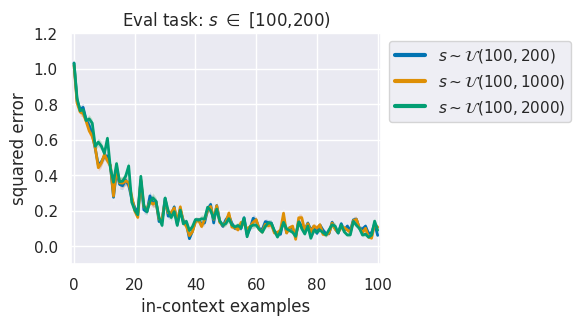

eval_task:  linear_regression_random_mapping-shift_low-500-shift_high-600
pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 8065.97it/s]


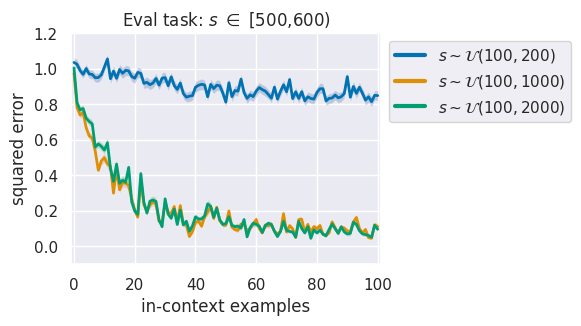

eval_task:  linear_regression_random_mapping-shift_low-3000-shift_high-3100
pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]


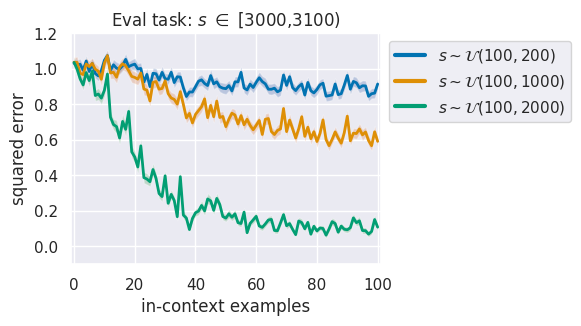

In [ ]:
task_para=None
step=-1



pretrain_tasks = [
    {
        "task_name":"linear_regression_random_mapping",
        "step":-1,
        "run_id":"59755988-b8eb-4a15-99cb-91f01ae169b1",
        "task_para": "linear_regression_random_mapping_scale0.4_shift100-200",
        'curve_name': '$s\sim\mathcal{U}(100,200)$'
    },
    {
        "task_name":"linear_regression_random_mapping",
        "step":-1,
        "run_id":"dfbe3fd7-d5a8-4821-8387-e126c9f0ff0c",
        "task_para": "linear_regression_random_mapping_scale0.4_shift100-1000",
        'curve_name': '$s\sim\mathcal{U}(100,1000)$'
    },
    {
        "task_name":"linear_regression_random_mapping",
        "step":-1,
        "run_id":"bb215dfc-5b63-4386-bc50-688f585db329",
        "task_para": "linear_regression_random_mapping_scale0.4_shift100-2000",
        'curve_name': '$s\sim\mathcal{U}(100,2000)$'
    },
    
]

eval_tasks = ['linear_regression_random_mapping-shift_low-100-shift_high-200', 'linear_regression_random_mapping-shift_low-500-shift_high-600', 'linear_regression_random_mapping-shift_low-3000-shift_high-3100']
for eval_task_name in eval_tasks:
    fig, ax = plt.subplots(1, 1)
    color=0
    print("eval_task: ", eval_task_name)
    for task in pretrain_tasks:
        task_name = task["task_name"]
        run_id = task["run_id"]
        step = task["step"]
        curve_name = task['curve_name'] 
        print("pt task: ",task_name)

        task_para = task["task_para"]
        run_path = os.path.join(run_dir, task_para, run_id)
        
        def valid_row(r):
            #print('555')

            if 'AR' in r.task or 'linear_quadratic' in r.task or '+' in r.task or \
                'rank' in r.task or "linear_regression_random_mapping" in r.task or \
                "linear_regression_random_mapping" in r.task or "linear_regression_diversity" in r.task or "power_regression" in r.task:
                #print(r.run_id , run_id)
                return r.run_id == run_id
            return r.task == task_name and r.run_id == run_id
        
        metrics = collect_results(run_dir, df, valid_row=valid_row, task_para=task_para, step=step)
        #print(metrics)
        _, conf = get_model_from_run(run_path, only_conf=True)
        n_dims = conf.model.n_dims

        models = relevant_model_names[task_name]

        metric = metrics[eval_task_name]
        
        #print(models, curve_name, metric)
        fig, ax = basic_plot_a_task(eval_task_name, metric, models=models, max_y=1.2, fig=fig, ax=ax, pretrain_task_name=curve_name, color=color, keep_legend=True)

        color+=1
        
        if "shift_low-100-shift_high-200" in eval_task_name:
            spec_str = '_100-200'
            ax.set_title("Eval task: " + '$s$ $\in$ [100,200)')
        elif "shift_low-500-shift_high-600" in eval_task_name:
            spec_str = '_500-600'
            ax.set_title("Eval task: " + '$s$ $\in$ [500,600)')
        elif "shift_low-3000-shift_high-3100" in eval_task_name:
            spec_str = '_3000-3100'
            ax.set_title("Eval task: " + '$s$ $\in$ [3000,3100)')

        
    
    plt.savefig('/data1/qxwang/codes/in-context-learning/results/figs_for_ICLR25/retrieval/'+eval_task_name+spec_str+'.pdf', bbox_inches='tight')
    plt.show()
    
    

    
#print(run_path)

## Reproduce Figure 5

eval_task:  quadratic_regression_random_mapping-shift_low-100-shift_high-200
pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]


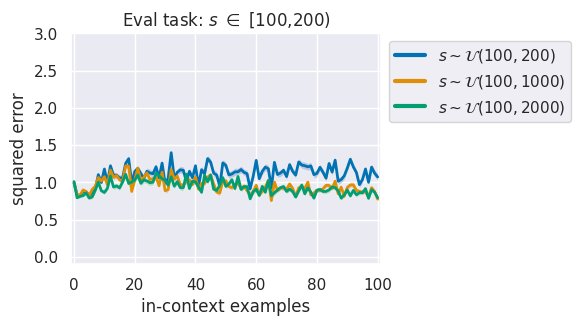

eval_task:  quadratic_regression_random_mapping-shift_low-500-shift_high-600
pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]


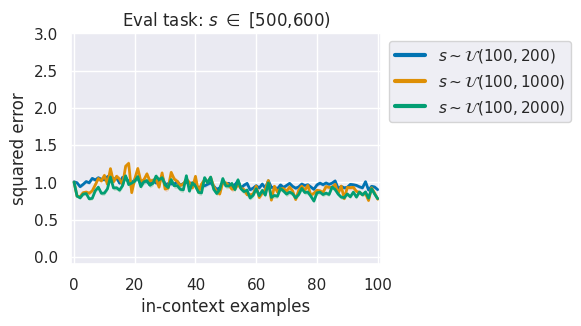

eval_task:  quadratic_regression_random_mapping-shift_low-3000-shift_high-3100
pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 21959.71it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]


pt task:  linear_regression_random_mapping


100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]


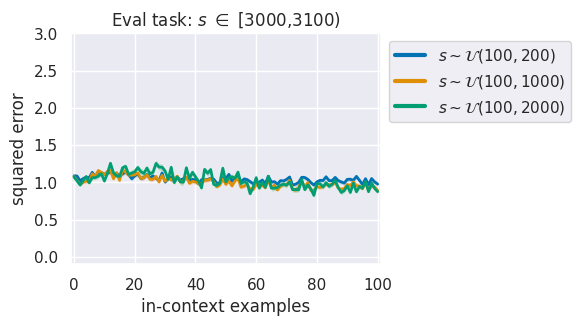

In [ ]:
task_para=None
step=-1

pretrain_tasks = [
    {
        "task_name":"linear_regression_random_mapping",
        "step":-1,
        "run_id":"59755988-b8eb-4a15-99cb-91f01ae169b1",
        "task_para": "linear_regression_random_mapping_scale0.4_shift100-200",
        'curve_name': '$s\sim\mathcal{U}(100,200)$'
    },
    {
        "task_name":"linear_regression_random_mapping",
        "step":-1,
        "run_id":"dfbe3fd7-d5a8-4821-8387-e126c9f0ff0c",
        "task_para": "linear_regression_random_mapping_scale0.4_shift100-1000",
        'curve_name': '$s\sim\mathcal{U}(100,1000)$'
    },
    {
        "task_name":"linear_regression_random_mapping",
        "step":-1,
        "run_id":"bb215dfc-5b63-4386-bc50-688f585db329",
        "task_para": "linear_regression_random_mapping_scale0.4_shift100-2000",
        'curve_name': '$s\sim\mathcal{U}(100,2000)$'
    },
    
]


eval_tasks = ['quadratic_regression_random_mapping-shift_low-100-shift_high-200', 'quadratic_regression_random_mapping-shift_low-500-shift_high-600', 'quadratic_regression_random_mapping-shift_low-3000-shift_high-3100']
for eval_task_name in eval_tasks:
    fig, ax = plt.subplots(1, 1)
    color=0
    print("eval_task: ", eval_task_name)
    for task in pretrain_tasks:
        task_name = task["task_name"]
        run_id = task["run_id"]
        step = task["step"]
        curve_name = task['curve_name'] 
        print("pt task: ",task_name)

        task_para = task["task_para"]
        run_path = os.path.join(run_dir, task_para, run_id)
        
        def valid_row(r):
            #print('555')

            if 'AR' in r.task or 'linear_quadratic' in r.task or '+' in r.task or \
                'rank' in r.task or "linear_regression_random_mapping" in r.task or \
                "linear_regression_random_mapping" in r.task or "linear_regression_diversity" in r.task or "power_regression" in r.task:
                #print(r.run_id , run_id)
                return r.run_id == run_id
            return r.task == task_name and r.run_id == run_id
        
        metrics = collect_results(run_dir, df, valid_row=valid_row, task_para=task_para, step=step)
        #print(metrics)
        _, conf = get_model_from_run(run_path, only_conf=True)
        n_dims = conf.model.n_dims

        models = relevant_model_names[task_name]

        metric = metrics[eval_task_name]


        fig, ax = basic_plot_a_task(eval_task_name, metric, models=models, max_y=3.0, fig=fig, ax=ax, pretrain_task_name=curve_name, color=color, keep_legend=True)

        color+=1
        
        if "shift_low-100-shift_high-200" in eval_task_name:
            spec_str = '_100-200'
            ax.set_title("Eval task: " + '$s$ $\in$ [100,200)')
        elif "shift_low-500-shift_high-600" in eval_task_name:
            spec_str = '_500-600'
            ax.set_title("Eval task: " + '$s$ $\in$ [500,600)')
        elif "shift_low-3000-shift_high-3100" in eval_task_name:
            spec_str = '_3000-3100'
            ax.set_title("Eval task: " + '$s$ $\in$ [3000,3100)')

        
    
    plt.savefig('/data1/qxwang/codes/in-context-learning/results/figs_for_ICLR25/retrieval/'+eval_task_name+spec_str+'.pdf', bbox_inches='tight')
    plt.show()

## Reproduce Figure 7

eval_task:  sqrt_regression
pt task:  multi_task


100%|██████████| 1/1 [00:00<00:00, 9597.95it/s]
/data1/qxwang/codes/in-context-learning/src/plot_utils.py:194: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1, max_y)


['Transformer']
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 190650.18it/s]


['Transformer']
pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 21959.71it/s]


['Transformer']
pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 44620.26it/s]

['Transformer']


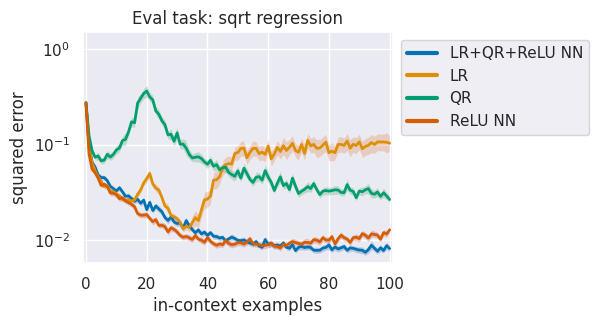

eval_task:  linear_quadratic_regression
pt task:  multi_task


100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]


['Transformer']
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 243854.88it/s]


['Transformer']
pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]


['Transformer']
pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 46603.38it/s]

['Transformer']


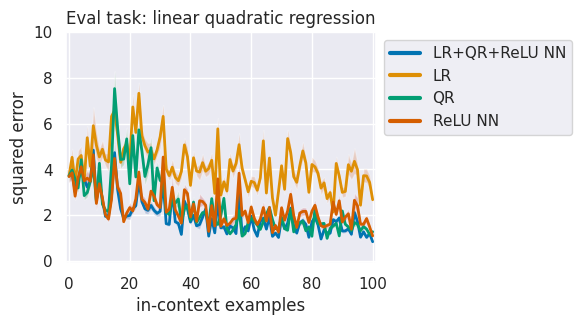

eval_task:  cubic_regression
pt task:  multi_task


100%|██████████| 1/1 [00:00<00:00, 23431.87it/s]


['Transformer']
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 219980.98it/s]


['Transformer']
pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 22310.13it/s]


['Transformer']
pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 41734.37it/s]

['Transformer']


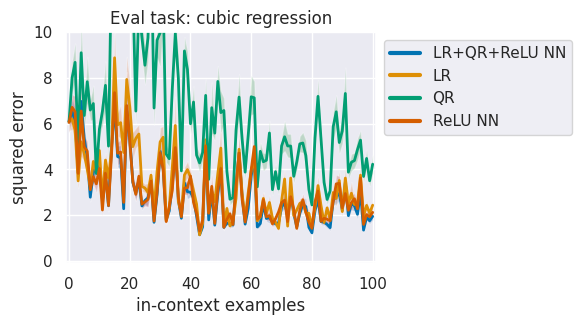

eval_task:  sigmoid_2nn_regression
pt task:  multi_task


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]
/data1/qxwang/codes/in-context-learning/src/plot_utils.py:194: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1, max_y)


['Transformer']
pt task:  linear_regression


100%|██████████| 15/15 [00:00<00:00, 227128.38it/s]


['Transformer']
pt task:  quadratic_regression


100%|██████████| 1/1 [00:00<00:00, 21399.51it/s]


['Transformer']
pt task:  relu_2nn_regression


100%|██████████| 2/2 [00:00<00:00, 36472.21it/s]

['Transformer']


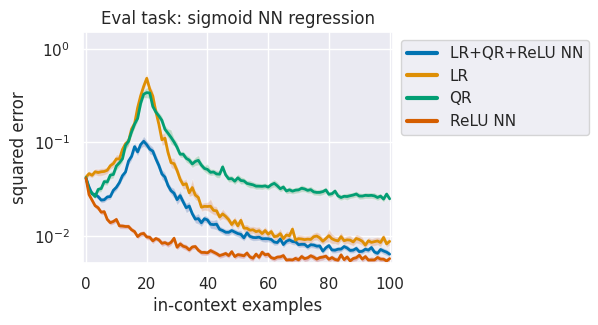

In [ ]:
task_para=None
step=-1
pretrain_tasks = [
    {
        "task_name":"multi_task",
        "step":200000,
        "run_id":"cb504505-5d6e-4d6e-96e8-52183ac3e578",
        "task_para": "linear_regression+quadratic_regression+relu_2nn_regression",
        'curve_name': 'LR+QR+ReLU NN'
    },
    {
        "task_name":"linear_regression",
        "step":200000,
        "run_id":"436c5fab-f524-4663-b7eb-155144477e05",
        'curve_name': 'LR'
    },
    {
        "task_name":"quadratic_regression",
        "step":200000,
        "run_id":"9f9b08e3-17f0-4310-af4d-437bd6ffaadb",
        'curve_name': 'QR'
    },
    {
        "task_name":"relu_2nn_regression",
        "step":200000,
        "run_id":"c9d388fe-0966-4b2b-9e0b-eb0fc9c9ad90",
        'curve_name': 'ReLU NN'
    },
    
]


eval_tasks = ["sqrt_regression", "linear_quadratic_regression", "cubic_regression","sigmoid_2nn_regression"]

for eval_task_name in eval_tasks:
    fig, ax = plt.subplots(1, 1)
    color=0
    print("eval_task: ", eval_task_name)
    for task in pretrain_tasks:
        task_name = task["task_name"]
        run_id = task["run_id"]
        step = task["step"]
        curve_name = task['curve_name'] 
        print("pt task: ",task_name)
        if task_name in ['autoregression', 'linear_quadratic_regression', 'multi_task', "linear_regression_keep_dim", "quadratic_regression_keep_dim",
                    "random_int_mapping", "linear_regression_random_mapping", "linear_regression_diversity","power_regression"]:
            task_para = task["task_para"]
            run_path = os.path.join(run_dir, task_para, run_id)
        else:
            run_path = os.path.join(run_dir, task_name, run_id)
        
        def valid_row(r):
            if 'AR' in r.task or 'linear_quadratic' in r.task or '+' in r.task or \
                'rank' in r.task or "random_int_mapping" in r.task or \
                "linear_regression_random_mapping" in r.task or "linear_regression_diversity" in r.task or "power_regression" in r.task:
                return r.run_id == run_id
            return r.task == task_name and r.run_id == run_id
        
        metrics = collect_results(run_dir, df, valid_row=valid_row, task_para=task_para, step=step)
        _, conf = get_model_from_run(run_path, only_conf=True)
        n_dims = conf.model.n_dims

        models = ['Transformer']

        
        metric = metrics[eval_task_name]


        if "scale" in eval_task_name:
            scale = float(eval_task_name.split("=")[-1])**2
        else:
            scale = 1.0

        trivial = 1.0 if "noisy" not in eval_task_name else (1+1/n_dims)
        print(models)

        if eval_task_name in ["sqrt_regression", "sigmoid_2nn_regression"]:
            max_y = 1.5
            ax.set_yscale('log') 
        elif eval_task_name in ['linear_quadratic_regression', 'cubic_regression']:
            max_y = 10.0
        else:
            max_y = 3.0
        fig, ax = basic_plot_a_task(eval_task_name, metric, models=models, max_y=max_y, fig=fig, ax=ax, pretrain_task_name=curve_name, color=color, keep_legend=True)

        color+=1
        

        ax.set_title("Eval task: " + fig_title_mapping[ eval_task_name])

            
        
        
    
    plt.savefig('/data1/qxwang/codes/in-context-learning/results/figs_for_ICLR25/retrieval/'+eval_task_name+spec_str+'.pdf', bbox_inches='tight')
    plt.show()
    
    

    
#print(run_path)